In [35]:
image_path = "C:/Users/basak/OneDrive/Masaüstü/DeepDreamProject/fox.jpg"
import numpy as np
import tensorflow as tf
import PIL.Image as Image
import matplotlib.pyplot as plt
import keras
from IPython.display import clear_output

In [36]:
def get_image(image_path, max_dim=None):
    image = Image.open(image_path)
    if max_dim:
        scale = max_dim / max(image.size)
        image = image.resize((round(image.size[0] * scale), round(image.size[1] * scale)), Image.ANTIALIAS)
    return np.array(image)

get_image(image_path, max_dim=500)

C:\Users\basak\AppData\Local\Temp\ipykernel_35404\2233562551.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((round(image.size[0] * scale), round(image.size[1] * scale)), Image.ANTIALIAS)


array([[[ 5,  4,  2],
        [ 5,  4,  2],
        [ 5,  4,  2],
        ...,
        [10,  4,  4],
        [12,  3,  4],
        [12,  3,  4]],

       [[ 5,  4,  2],
        [ 5,  4,  2],
        [ 5,  4,  2],
        ...,
        [10,  4,  4],
        [10,  4,  4],
        [11,  3,  4]],

       [[ 6,  5,  3],
        [ 6,  5,  3],
        [ 5,  4,  2],
        ...,
        [ 9,  3,  3],
        [10,  4,  4],
        [10,  4,  4]],

       ...,

       [[18,  4,  1],
        [18,  4,  1],
        [18,  4,  1],
        ...,
        [13,  3,  1],
        [13,  3,  1],
        [13,  3,  1]],

       [[18,  4,  1],
        [18,  4,  1],
        [18,  4,  1],
        ...,
        [13,  3,  1],
        [13,  3,  1],
        [13,  3,  1]],

       [[19,  5,  2],
        [19,  5,  2],
        [18,  4,  1],
        ...,
        [13,  3,  1],
        [13,  3,  1],
        [13,  3,  1]]], dtype=uint8)

C:\Users\basak\AppData\Local\Temp\ipykernel_35404\2233562551.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((round(image.size[0] * scale), round(image.size[1] * scale)), Image.ANTIALIAS)


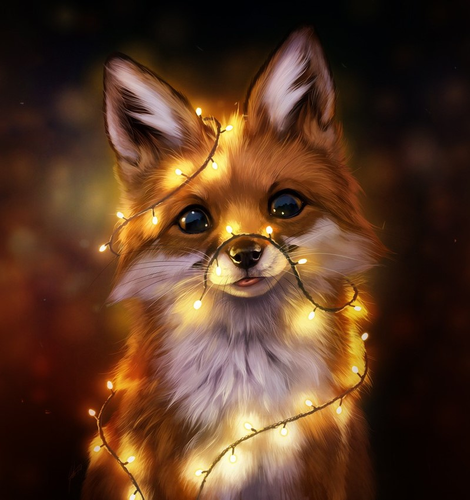

In [39]:
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(image):
   display(Image.fromarray(np.array(image)))
    
    
# Load the image
image = get_image(image_path, max_dim=500)


  
show(image)



In [40]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [41]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [42]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [43]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [44]:
deepdream = DeepDream(dream_model)

In [49]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))


    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))
    
    result = deprocess(img)
  
    show(result)
    return result
    
    

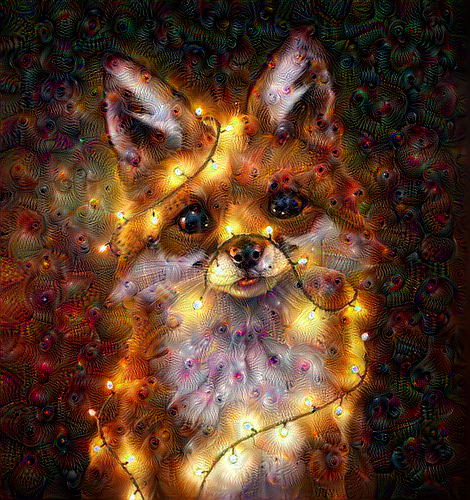

Step 100, loss 2.2309951782226562


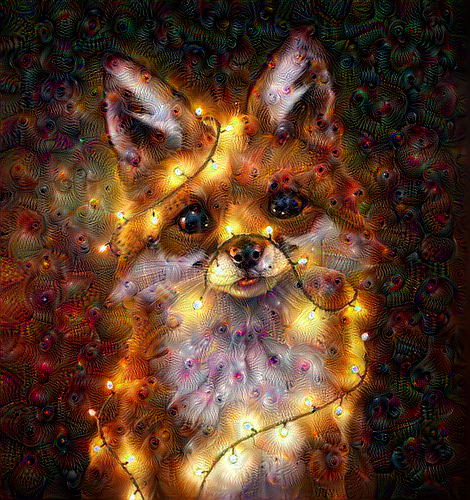

In [50]:
dream_img = run_deep_dream_simple(img=image, 
                                  steps=100, step_size=0.01)

In [51]:
#save the image
Image.fromarray(np.array(dream_img)).save("C:/Users/basak/OneDrive/Masaüstü/DeepDreamProject/fox_dream.jpg")


<h2>Neural style transfer</h2>
    

In [52]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [53]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [54]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [68]:
ahri_path =    "C:/Users/basak/OneDrive/Masaüstü/DeepDreamProject/ahri.jpeg"
fox_path =  "C:/Users/basak/OneDrive/Masaüstü/DeepDreamProject/fox.jpg"

In [69]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [72]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
  

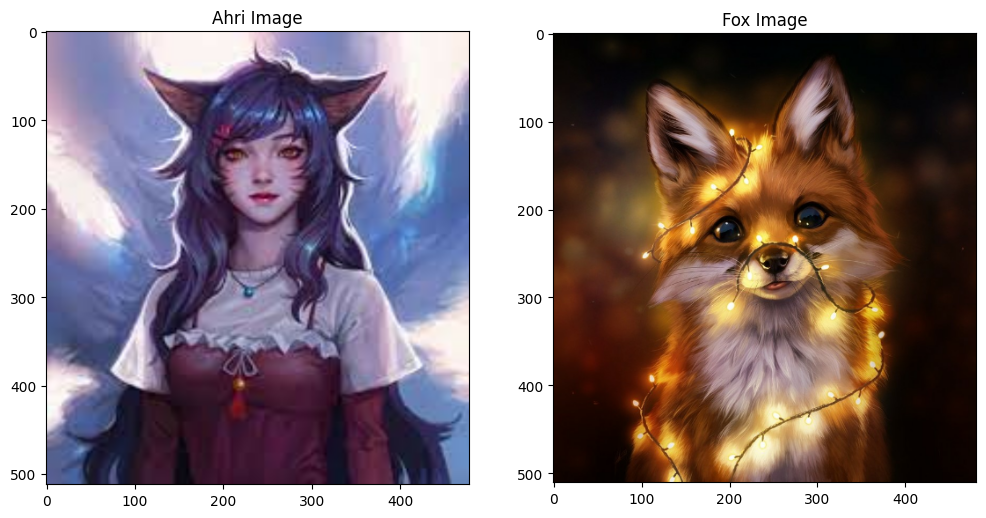

In [73]:
ahri_image = load_img(ahri_path)
fox_image = load_img(fox_path)

    
plt.subplot(1, 2, 1)
imshow(ahri_image, 'Ahri Image')

plt.subplot(1, 2, 2)
imshow(fox_image, 'Fox Image')

In [74]:
x = tf.keras.applications.vgg19.preprocess_input(ahri_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 190s 0us/step


TensorShape([1, 1000])

In [75]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('feather_boa', 0.24329081),
 ('mask', 0.10237506),
 ('wig', 0.089676365),
 ('breastplate', 0.08600199),
 ('stage', 0.023483135)]

In [76]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 26s 0us/step

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [77]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [78]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [80]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(fox_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv2
  shape:  (1, 511, 481, 64)
  min:  0.0
  max:  2542.5005
  mean:  87.21125

block2_conv2
  shape:  (1, 255, 240, 128)
  min:  0.0
  max:  5982.278
  mean:  77.31852

block3_conv2
  shape:  (1, 127, 120, 256)
  min:  0.0
  max:  10108.198
  mean:  107.46829

block4_conv2
  shape:  (1, 63, 60, 512)
  min:  0.0
  max:  15919.408
  mean:  246.59135

block5_conv2
  shape:  (1, 31, 30, 512)
  min:  0.0
  max:  1174.1791
  mean:  11.92157



In [81]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [82]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [84]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(ahri_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv2
    shape:  (1, 64, 64)
    min:  6.1123676
    max:  664556.25
    mean:  9423.938

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.6987113
    max:  175523.0
    mean:  8427.279

   block3_conv2
    shape:  (1, 256, 256)
    min:  30.417608
    max:  236987.58
    mean:  16815.572

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  3013586.0
    mean:  73817.13

   block5_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  16707.586
    mean:  224.32811

Contents:
   block5_conv2
    shape:  (1, 32, 29, 512)
    min:  0.0
    max:  1279.2755
    mean:  13.886904


In [85]:
style_targets = extractor(fox_image)['style']
content_targets = extractor(ahri_image)['content']

In [86]:
image = tf.Variable(ahri_image) 


In [87]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [88]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [89]:
style_weight=1e-2
content_weight=1e4

In [90]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [91]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

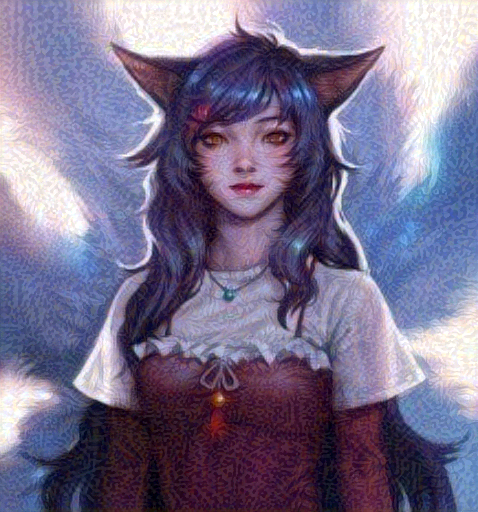

In [92]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

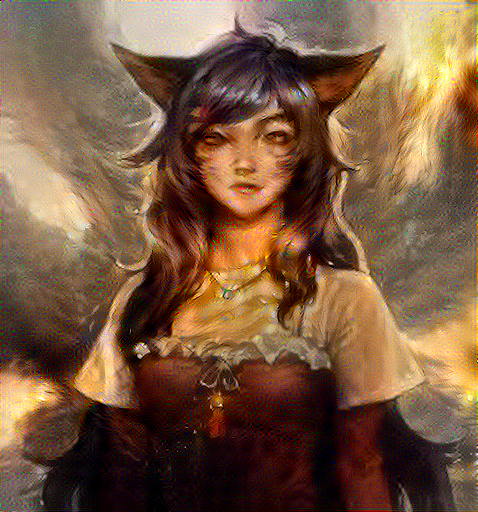

Train step: 1000
Total time: 185.5


In [93]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [94]:
total_variation_weight=30

In [95]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [97]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(ahri_image)

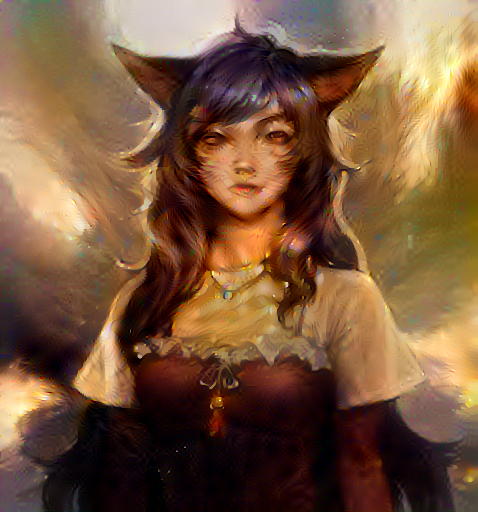

Train step: 1000
Total time: 184.3


In [98]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [99]:
#time to save the image
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)